# Imports

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# DATABASE EXPLORATION

In [3]:
# Connect to database
path_to_db = "../data/DB/olist.db"
connection = sqlite3.connect(path_to_db)

# Create a cursor object to execute SQL queries
cursor = connection.cursor()

We will start by exploring the table related to customers : customers.

In [7]:
customers_info = """
    SELECT DISTINCT
    c.customer_unique_id, c.customer_id, c.customer_state,c.customer_city
    FROM customers c
"""
    # ,g.geolocation_lat, g.geolocation_lng
    # LEFT JOIN geoloc g ON c.customer_zip_code_prefix = g.geolocation_zip_code_prefix

In [13]:
# Display the results in a pandas dataframe
df_customers = pd.read_sql_query(customers_info, connection)
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_unique_id  99441 non-null  object
 1   customer_id         99441 non-null  object
 2   customer_state      99441 non-null  object
 3   customer_city       99441 non-null  object
dtypes: object(4)
memory usage: 3.0+ MB


## How many customers ? Where are they living ?

In [5]:
print(f"Number of customers : {len(df_customers['customer_unique_id'].unique())}")
print(f"Customers are from {len(df_customers['customer_state'].unique())} different states and {len(df_customers['customer_city'].unique())} different cities")

# get the number of orders per customer
orders_by_customer = df_customers.groupby("customer_unique_id")["customer_id"].count().sort_values(ascending=False)
# get min and max number of orders
min_orders = orders_by_customer.min()
max_orders = orders_by_customer.max()
# get the average number of orders
average_orders = orders_by_customer.mean()

print(f"The number of orders can be from {min_orders} to {max_orders} with an average of {round(average_orders, 2)} orders per customer")


Number of customers : 96096
Customers are from 27 different states and 4119 different cities
The number of orders can be from 1 to 17 with an average of 1.03 orders per customer


In [6]:
# Group customer by state and cities then count the number of customers in each group
customers_by_state = df_customers.groupby("customer_state")["customer_unique_id"].count().sort_values(ascending=False)
customers_by_state.head()

customer_state
SP    41746
RJ    12852
MG    11635
RS     5466
PR     5045
Name: customer_unique_id, dtype: int64

In [7]:
# get the proportion of customers by state
customers_by_state = customers_by_state.reset_index()
customers_by_state.columns = ["state", "number_of_customers"]
customers_by_state["percentage"] = round(customers_by_state["number_of_customers"] / customers_by_state["number_of_customers"].sum() * 100)
customers_by_state.head()

,state,number_of_customers,percentage
0,SP,41746,42.0
1,RJ,12852,13.0
2,MG,11635,12.0
3,RS,5466,5.0
4,PR,5045,5.0


In [8]:
# Replace state name by OTHER if the percentage of customers is less than 1%
customers_by_state.loc[customers_by_state["percentage"] < 5, "state"] = "OTHER"
customers_by_state = customers_by_state.groupby("state")["number_of_customers"].sum().sort_values(ascending=False)
customers_by_state = customers_by_state.reset_index()

customers_by_state

,state,number_of_customers
0,SP,41746
1,OTHER,22697
2,RJ,12852
3,MG,11635
4,RS,5466
5,PR,5045


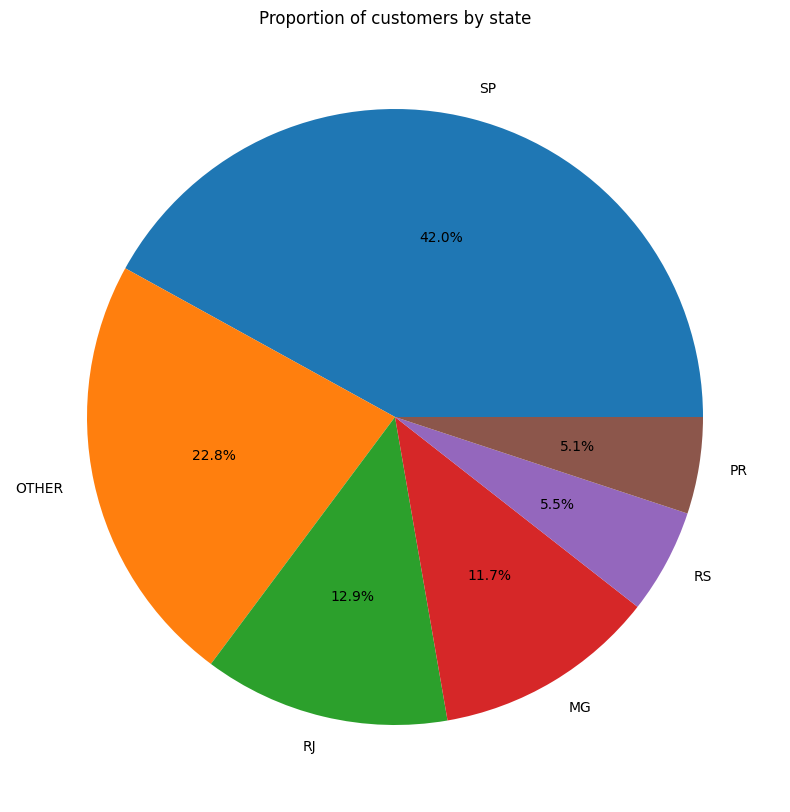

In [9]:
# plot the proportion of customers by state
plt.figure(figsize=(10, 10))
plt.pie(customers_by_state["number_of_customers"], labels=customers_by_state["state"], autopct='%1.1f%%')
plt.title("Proportion of customers by state")
plt.show()

## Orders related informations

In [14]:
query = """
    SELECT c.customer_unique_id, c.customer_zip_code_prefix
    , o.order_id, o.order_status, o.order_purchase_timestamp, o.order_approved_at, o.order_delivered_carrier_date, o.order_delivered_customer_date, o.order_estimated_delivery_date
    FROM customers c
    LEFT JOIN orders o ON c.customer_id = o.customer_id
"""
    # , r.review_score, COALESCE(LENGTH(r.review_comment_message),0) as review_length
    # , p.product_description_lenght, p.product_photos_qty
    # LEFT JOIN order_items oi ON o.order_id = oi.order_id
    # LEFT JOIN order_reviews r ON o.order_id = r.order_id
    # LEFT JOIN products p ON oi.product_id = p.product_id
    # , t.product_category_name_english
    # LEFT JOIN translation t ON p.product_category_name = t.product_category_name

df_orders = pd.read_sql_query(query, connection)
df_orders.head()

,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,861eff4711a542e4b93843c6dd7febb0,14409,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00
1,290c77bc529b7ac935b93aa66c333dc3,9790,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00
2,060e732b5b29e8181a18229c7b0b2b5e,1151,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00
3,259dac757896d24d7702b9acbbff3f3c,8775,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00
4,345ecd01c38d18a9036ed96c73b8d066,13056,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00


In [11]:
# first and last order dates
first_order_date = df_orders["order_purchase_timestamp"].min()
last_order_date = df_orders["order_purchase_timestamp"].max()
# total orders
total_orders = len(df_orders["order_id"].unique())

print(f"Orders are from {first_order_date} to {last_order_date} for a total of {total_orders} orders")

Orders are from 2016-09-04 21:15:19 to 2018-10-17 17:30:18 for a total of 99441 orders


In [12]:
# Different order statuses
df_orders["order_status"].unique()

array(['delivered', 'canceled', 'invoiced', 'shipped', 'processing',
       'unavailable', 'approved', 'created'], dtype=object)

In [13]:
# Plot the number of orders by status
orders_by_status = df_orders.groupby("order_status")["order_id"].count().sort_values(ascending=False)
orders_by_status = orders_by_status.reset_index()
orders_by_status.columns = ["status", "number_of_orders"]
orders_by_status["percentage"] = round(orders_by_status["number_of_orders"] / orders_by_status["number_of_orders"].sum() * 100)

fig = px.histogram(orders_by_status, x="status", y="number_of_orders", title="Number of orders by status")
fig.show()

### Orders logistics

## Evolution of orders with time

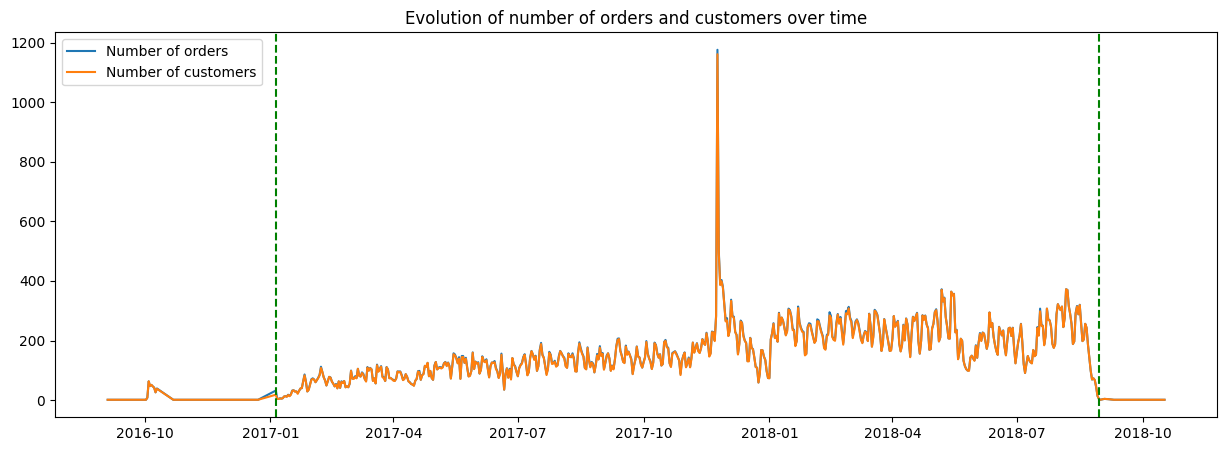

In [21]:
# Plot the evolution of number of orders over time
df_orders["order_purchase_timestamp"] = pd.to_datetime(df_orders["order_purchase_timestamp"])
orders_by_date = df_orders.groupby(df_orders["order_purchase_timestamp"].dt.date)["order_id"].count()
orders_by_date = orders_by_date.reset_index()
orders_by_date.columns = ["date", "number_of_orders"]

# Plot the evolution of number of customers over time
customers_by_date = df_orders.groupby(df_orders["order_purchase_timestamp"].dt.date)["customer_unique_id"].nunique()
customers_by_date = customers_by_date.reset_index()
customers_by_date.columns = ["date", "number_of_customers"]

# PLot the evolution of number of orders and customers over time
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(orders_by_date["date"], orders_by_date["number_of_orders"], label="Number of orders")
ax.plot(customers_by_date["date"], customers_by_date["number_of_customers"], label="Number of customers")
ax.set_title("Evolution of number of orders and customers over time")
# Add vertical axis at 05-01-2017 and 30-08-2018 converted to datetime
ax.axvline(pd.to_datetime("2017-01-05"), color="green", linestyle="--")
ax.axvline(pd.to_datetime("2018-08-30"), color="green", linestyle="--")
ax.legend()
plt.show()

In [28]:
# What is happening on november 2017
# Convert 'date' column to pd.Timestamp
customers_by_date["date"] = pd.to_datetime(customers_by_date["date"])
nov = customers_by_date.loc[
    (customers_by_date["date"] > pd.Timestamp("2017-11-01"))
    & (customers_by_date["date"] < pd.Timestamp("2017-11-30"))
]

# Plot the detail using plotly
fig = px.line(nov, x="date", y="number_of_customers", title="Number of customers in November 2017")
fig.show()

In [30]:
# count unique customers on  24th november 2017
nov_24 = df_orders.loc[df_orders["order_purchase_timestamp"].dt.date == pd.Timestamp("2017-11-24")]
nov_24

,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,processing_time,month,year,month_year


#### Processing time

In [15]:
# Get the processing time of the orders
df_orders["order_purchase_timestamp"] = pd.to_datetime(df_orders["order_purchase_timestamp"])
df_orders["order_delivered_customer_date"] = pd.to_datetime(df_orders["order_delivered_customer_date"])
df_orders["processing_time"] = df_orders["order_delivered_customer_date"] - df_orders["order_purchase_timestamp"]
df_orders["processing_time"] = df_orders["processing_time"].dt.days

# get the average processing time
average_processing_time = df_orders["processing_time"].mean()
print(f"The average processing time is {round(average_processing_time, 2)} days")

The average processing time is 12.09 days


#### Deliveries ( using SQL query to transform data)

In [ ]:
late_orders_query = """
    SELECT
        order_id,
        customer_id,
        order_purchase_timestamp,
        order_delivered_customer_date,
        order_estimated_delivery_date,
        julianday(order_delivered_customer_date) - julianday(order_estimated_delivery_date) as delay
    FROM orders
    WHERE order_status = 'delivered'
        AND order_delivered_customer_date IS NOT NULL
        AND order_status != 'canceled'
        -- Select recent orders (past 3 months)
        AND julianday(
            (SELECT MAX(order_purchase_timestamp) FROM orders)
        ) - julianday(order_purchase_timestamp) <= 90
        AND (julianday(order_delivered_customer_date) - julianday(order_estimated_delivery_date)) >= 2
    ORDER BY order_purchase_timestamp DESC
"""

df_late_orders = pd.read_sql_query(late_orders_query, connection)

In [16]:
df_late_orders["order_purchase_timestamp"] = pd.to_datetime(df_late_orders["order_purchase_timestamp"])
df_late_orders["order_delivered_customer_date"] = pd.to_datetime(df_late_orders["order_delivered_customer_date"])
df_late_orders["order_estimated_delivery_date"] = pd.to_datetime(df_late_orders["order_estimated_delivery_date"])

In [ ]:
fig = px.histogram(df_late_orders, x="delay", title="Distribution of delays in delivery in days", nbins=10, text_auto=True)
fig.update_layout(
    xaxis_title="Delay in days",
    yaxis_title="Number of orders",
)
fig.show()

### Orders frequency.

Back to our previously queried dataframe

In [18]:
# For the customers with more than one order, get the number of days between an order and the previous one for each customer. The first order should be considered as 0
df_orders = df_orders.sort_values(by=["customer_unique_id", "order_purchase_timestamp"])
df_grouped = df_orders.groupby("customer_unique_id")

result = df_grouped.agg(
    last_order_date=("order_purchase_timestamp", "max"),
    total_orders=("order_id", "count"),
)

# Average days between orders
df_orders["days_between_orders"] = (
    df_grouped["order_purchase_timestamp"].diff().dt.days.fillna(0).fillna(0)
)
average_days_between_orders = df_orders.groupby("customer_unique_id")["days_between_orders"].mean().fillna(0)

# Add average to results
result["average_days_between_orders"] = average_days_between_orders

# Merge column order_id back to the results
# result = result.merge(df_orders[["customer_unique_id", "order_id"]], how="left", on="customer_unique_id")

result = result.reset_index()

result.loc[result["total_orders"] > 1].head()

,customer_unique_id,last_order_date,total_orders,average_days_between_orders
33,00172711b30d52eea8b313a7f2cced02,2018-08-13 09:14:07,2,8.0
106,004288347e5e88a27ded2bb23747066c,2018-01-14 07:36:54,2,85.0
124,004b45ec5c64187465168251cd1c9c2f,2018-05-26 19:42:48,2,133.5
144,0058f300f57d7b93c477a131a59b36c3,2018-03-22 18:09:41,2,15.5
249,00a39521eb40f7012db50455bf083460,2018-06-03 10:12:57,2,5.0


In [19]:
df_orders.query("customer_unique_id == '00172711b30d52eea8b313a7f2cced02'")

,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,processing_time,days_between_orders
19299,00172711b30d52eea8b313a7f2cced02,45200,bb874c45df1a3c97842d52f31efee99a,delivered,2018-07-28 00:23:49,2018-07-28 00:35:19,2018-07-31 15:57:00,2018-08-07 19:28:41,2018-08-22 00:00:00,10.0,0.0
35608,00172711b30d52eea8b313a7f2cced02,45200,c306eca42d32507b970739b5b6a5a33a,canceled,2018-08-13 09:14:07,None,None,NaT,2018-09-05 00:00:00,NaN,16.0


In [20]:
# split last order date into date and time
result["last_order_time"] = result["last_order_date"].dt.time
result["last_order_date"] = result["last_order_date"].dt.date

result.head()

,customer_unique_id,last_order_date,total_orders,average_days_between_orders,last_order_time
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,1,0.0,10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,1,0.0,11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10,1,0.0,21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,1,0.0,20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14,1,0.0,19:45:42


In [21]:
result.describe()

,total_orders,average_days_between_orders
count,96096.000000,96096.000000
mean,1.034809,1.275598
std,0.214384,11.984673
min,1.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,0.000000
max,17.000000,304.000000


Who are the most recent customers ?

In [22]:
df_orders.sort_values(by="order_purchase_timestamp", ascending=False).head(10)

,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,processing_time,days_between_orders
85415,87ab9fec999db8bd5774917de3cdf01c,18077,10a045cdf6a5650c21e9cfeb60384c16,canceled,2018-10-17 17:30:18,None,None,NaT,2018-10-30 00:00:00,NaN,0.0
69139,262e1f1e26e92e86375f86840b4ffd63,64600,b059ee4de278302d550a3035c4cdb740,canceled,2018-10-16 20:16:02,None,None,NaT,2018-11-12 00:00:00,NaN,127.0
68312,af5454198a97379394cacf676e1e96cb,11900,a2ac6dad85cf8af5b0afb510a240fe8c,canceled,2018-10-03 18:55:29,None,None,NaT,2018-10-16 00:00:00,NaN,30.0
75902,634420a0ea42302205032ed44ac7fccc,27175,616fa7d4871b87832197b2a137a115d2,canceled,2018-10-01 15:30:09,None,None,NaT,2018-10-23 00:00:00,NaN,46.0
75985,9bb92bebd4cb7511e1a02d5e50bc4655,7176,392ed9afd714e3c74767d0c4d3e3f477,canceled,2018-09-29 09:13:03,None,None,NaT,2018-10-15 00:00:00,NaN,0.0
75807,ba84da8c159659f116329563a0a981dd,25635,869997fbe01f39d184956b5c6bccfdbe,canceled,2018-09-26 08:40:15,None,None,NaT,2018-10-25 00:00:00,NaN,22.0
33139,9c3af16efacb7aa06aa3bc674556c5d6,30170,5aac76cf7b07dd06fa4d50bf461d2f40,canceled,2018-09-25 11:59:18,None,None,NaT,2018-10-11 00:00:00,NaN,53.0
41350,08642cd329066fe11ec63293f714f2f8,33030,ed3efbd3a87bea76c2812c66a0b32219,canceled,2018-09-20 13:54:16,None,None,NaT,2018-10-17 00:00:00,NaN,60.0
1087,ef0103e9602d12594d19c2b666219bc1,30810,bd35b677fd239386e9861d11ae98ab56,canceled,2018-09-17 17:21:16,None,None,NaT,2018-10-01 00:00:00,NaN,5.0
70913,c1ee153508c6b785b491443a95ff364e,89300,ea844c92cf978ea23321fa7fe5871761,canceled,2018-09-13 09:56:12,None,None,NaT,2018-09-27 00:00:00,NaN,0.0


In [23]:
df_orders["order_status"].unique()

array(['delivered', 'canceled', 'shipped', 'unavailable', 'invoiced',
       'processing', 'created', 'approved'], dtype=object)

We'd like to keep all categories to keep track on clients that ordered abd are waiting for they order to be approved and to keep track on customers that canceled their order. What is "unavailable" ? Is this the information ? We can work on this information to check if it was delivered

In [24]:
df_orders.loc[df_orders["order_status"] == "unavailable"].info()

<class 'pandas.core.frame.DataFrame'>
Index: 609 entries, 83995 to 96595
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_unique_id             609 non-null    object        
 1   customer_zip_code_prefix       609 non-null    int64         
 2   order_id                       609 non-null    object        
 3   order_status                   609 non-null    object        
 4   order_purchase_timestamp       609 non-null    datetime64[ns]
 5   order_approved_at              609 non-null    object        
 6   order_delivered_carrier_date   0 non-null      object        
 7   order_delivered_customer_date  0 non-null      datetime64[ns]
 8   order_estimated_delivery_date  609 non-null    object        
 9   processing_time                0 non-null      float64       
 10  days_between_orders            609 non-null    float64       
dtypes: datetime64[ns](

It seems that the order nas never delivered, neither to the customer, neither to the carrier. It concerns 609 orders.

## Investigating on the reviews.

In [25]:
reviews_query = """
    SELECT o.order_id, c.customer_unique_id, o.order_status
    , COALESCE(r.review_score,0) as review_score, COALESCE(LENGTH(r.review_comment_message),0) as review_length, DATE(r.review_creation_date) as review_reation_date
    FROM orders o
    JOIN customers c ON o.customer_id = c.customer_id
    LEFT JOIN order_reviews r ON o.order_id = r.order_id
"""

order_reviews = pd.read_sql_query(reviews_query, connection)
order_reviews.head()

,order_id,customer_unique_id,order_status,review_score,review_length,review_reation_date
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,4,170,2017-10-11
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,delivered,4,20,2018-08-08
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,delivered,5,0,2018-08-18
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,delivered,5,105,2017-12-03
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,delivered,5,0,2018-02-17


In [26]:
unavailable_order_reviews = order_reviews.loc[order_reviews["order_status"] == "unavailable"]
unavailable_order_reviews["review_score"].value_counts()

review_score
1    463
2     43
5     36
3     35
4     20
0     14
Name: count, dtype: int64

14 products have not been reviewed.

In [27]:
unavailable_order_reviews.loc[unavailable_order_reviews["review_score"] == 0]

,order_id,customer_unique_id,order_status,review_score,review_length,review_reation_date
3475,2f30c0b1905c65a8ff6c6358bc909625,215e0a9044344dca7820b462c60bd206,unavailable,0,0,None
4627,b7be5e58fd37e6165dbb39e8362c8446,2d6e75f5a4a33d3a936f1ea68ac9bf01,unavailable,0,0,None
38306,5c4e4e1d3abaee058758731094e9a7cc,5192c897072033288df55bd01b0e5737,unavailable,0,0,None
43918,0a5c74ccc786ced7903270de9d6c170a,db6232ea09754a4b150da1dafb82fe45,unavailable,0,0,None
48650,974f9f87a3bad01b2ac72fe987505e9b,e075305a11bf4cc09e8395bd97266a1e,unavailable,0,0,None
49916,5f2dbe00a1732133a6809ae1af554123,359328b5ede8c2758bc8f1740565dda3,unavailable,0,0,None
52715,31b91033dcb0502e616f40ced16dccc6,864adb6f60fff0c2a11613045507d350,unavailable,0,0,None
52724,55aa287c6ca17e8c3262b9ef1e12fac6,429fbf4ee20691b0ae84c84c3ebc6897,unavailable,0,0,None
52928,adf5a3d223336c6b7965f3027bb7ddc2,af65b6eb3336048acc95ef62a4ac94c3,unavailable,0,0,None
70398,cd80f267aabc7357c2caaa8848e1cd3c,b52378d2bae15325d2dffddb403ff3e3,unavailable,0,0,None


The 14 missing reviews belong to products that don't have an order_status.

Might decide to drop those 609 rows...

## Do customers leave reviews and rate the product ?

In [28]:
# Get the total of reviews given by a customer and the average review score
reviews_by_customer = order_reviews.groupby("customer_unique_id")["review_score"].agg(
    total_reviews="count", average_review_score="mean"
)
reviews_by_customer = reviews_by_customer.reset_index()

reviews_by_customer.loc[reviews_by_customer["total_reviews"] == 0].head()

,customer_unique_id,total_reviews,average_review_score


In [29]:
order_reviews.loc[(order_reviews["review_length"] < 6)].sort_values(by="review_length", ascending=False)

,order_id,customer_unique_id,order_status,review_score,review_length,review_reation_date
58892,0f1a032292563a581f27eac807f97a05,b5b2a7fd4d491c96d488db899e42e0e2,delivered,5,5,2018-07-31
22189,d5499e385aef94ea76d2ea5e6a73e60a,0d1b072f720c3e2778a1b93b937ec8ac,delivered,5,5,2017-03-04
54021,0eb7dc4e9168fd2e3bc791983492d99a,22f2ac2a52ef231ad6d14660da9054ee,delivered,5,5,2018-07-13
28262,c588d6fe9640b6198171ed8c30981057,c49003818eeffa06a089d621c92f05c0,delivered,5,5,2018-07-10
96735,eddc2675550fd30e8c067b3fdd08ad60,b903cf485dbbbca3620a415d018565f6,delivered,5,5,2017-11-23
...,...,...,...,...,...,...
33769,b1a000260e2f3760e5ec18566db7d592,0f2bf926e0f3cdc9092f3388063eec2e,delivered,4,0,2017-06-30
33772,85b4db0acc8f67917cb9245d8547ecaa,fe40c8ed5d902c8ec1032044a223b285,shipped,1,0,2018-03-24
33773,10856b02e17c5d56a06c2ee75079d338,6c00d2b9180327258ff03b6acd57ded1,delivered,5,0,2018-01-11
33774,9645c5cc1c315607f2524b2189d3efe1,be96f24255f8b90d5401437eb2f56c83,delivered,5,0,2017-07-07


In [30]:
order_reviews["left_review"] = order_reviews.apply(lambda x: 1 if x["review_length"] >= 100 else 0, axis=1)
order_reviews.drop(columns=["review_length"], inplace=True)
order_reviews.head()

,order_id,customer_unique_id,order_status,review_score,review_reation_date,left_review
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,4,2017-10-11,1
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,delivered,4,2018-08-08,0
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,delivered,5,2018-08-18,0
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,delivered,5,2017-12-03,1
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,delivered,5,2018-02-17,0


In [31]:
# add to the result dataframe
result = result.merge(reviews_by_customer, on="customer_unique_id", how="left")
result.head()

,customer_unique_id,last_order_date,total_orders,average_days_between_orders,last_order_time,total_reviews,average_review_score
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,1,0.0,10:56:27,1,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,1,0.0,11:11:27,1,4.0
2,0000f46a3911fa3c0805444483337064,2017-03-10,1,0.0,21:05:03,1,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,1,0.0,20:29:41,1,4.0
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14,1,0.0,19:45:42,1,5.0


## What do they order and how much they pay?

In [32]:
products_query = """
    SELECT c.customer_unique_id, o.order_id, oi.price, oi.freight_value, t.product_category_name_english, p.product_description_lenght, p.product_photos_qty
    FROM customers c
    LEFT JOIN orders o ON c.customer_id = o.customer_id
    JOIN order_items oi ON o.order_id = oi.order_id
    JOIN products p ON oi.product_id = p.product_id
    LEFT JOIN translation t ON p.product_category_name = t.product_category_name
"""

df_orders_detail = pd.read_sql_query(products_query, connection)
df_orders_detail.head()

,customer_unique_id,order_id,price,freight_value,product_category_name_english,product_description_lenght,product_photos_qty
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,124.99,21.88,office_furniture,1141.0,1.0
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,289.00,46.48,housewares,1002.0,3.0
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,139.94,17.79,office_furniture,955.0,1.0
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,149.94,23.36,office_furniture,1066.0,1.0
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,230.00,22.25,home_confort,407.0,1.0


In [33]:
# group by customer and order then create a column product_category which is a list of all the products bought by the customer
df_orders_detail_agg = df_orders_detail.groupby(["customer_unique_id", "order_id"]).agg(
    product_category=("product_category_name_english", lambda x: list(x)),
    total_price=("price", "sum"),
    total_freight=("freight_value", "sum"),
    avg_product_description_lenght=("product_description_lenght", "mean"),
    avg_product_photos_qty=("product_photos_qty", "mean"),
).reset_index()

df_orders_detail_agg.tail()

,customer_unique_id,order_id,product_category,total_price,total_freight,avg_product_description_lenght,avg_product_photos_qty
98661,fffcf5a5ff07b0908bd4e2dbc735a684,725cf8e9c24e679a8a5a32cb92c9ce1e,"[health_beauty, health_beauty]",1570.00,497.42,478.5,1.0
98662,fffea47cd6d3cc0a88bd621562a9d061,c71b9252fd7b3b263aaa4cb09319a323,[baby],64.89,19.69,506.0,2.0
98663,ffff371b4d645b6ecea244b27531430a,fdc45e6c7555e6cb3cc0daca2557dbe1,[auto],89.90,22.56,716.0,5.0
98664,ffff5962728ec6157033ef9805bacc48,94d3ee0bc2a0af9d4fa47a4d63616e8d,[watches_gifts],115.00,18.69,591.0,3.0
98665,ffffd2657e2aad2907e67c3e9daecbeb,f79a35da168301ae56922475da21117b,[perfumery],56.99,14.57,1003.0,2.0


## Select data according to RFM - Recency, Frequency, Monetary

In [5]:
rfm_query = """
    SELECT
    c.customer_unique_id,
    o.order_id,
    o.order_status, o.order_purchase_timestamp,
    oi.price, oi.freight_value
    FROM orders o
    LEFT JOIN customers c ON o.customer_id = c.customer_id
    LEFT JOIN order_items oi ON o.order_id = oi.order_id
"""
df_rfm = pd.read_sql_query(rfm_query, connection)
df_rfm.head()


,customer_unique_id,order_id,order_status,order_purchase_timestamp,price,freight_value
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,29.99,8.72
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,118.70,22.76
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,159.90,19.22
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,45.00,27.20
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,19.90,8.72


# GET FULL INFORMATION

In [4]:
details_query = """
    SELECT
        c.customer_unique_id, c.customer_state, c.customer_zip_code_prefix,
        o.order_id, o.order_status, o.order_purchase_timestamp, o.order_approved_at, o.order_delivered_customer_date, o.order_estimated_delivery_date,
        oi.price as item_price, oi.freight_value,
        pmt.payment_value, pmt.payment_sequential, pmt.payment_type, pmt.payment_installments,
        s.seller_id, s.seller_state, s.seller_zip_code_prefix,
        COALESCE(r.review_score,0) as review_score, COALESCE(LENGTH(r.review_comment_message),0) as review_length,
        p.product_description_lenght, p.product_photos_qty, p.product_category_name,
        t.product_category_name_english
    FROM order_items oi
    LEFT JOIN orders o ON oi.order_id = o.order_id
    LEFT JOIN customers c ON o.customer_id = c.customer_id
    LEFT JOIN order_pymts pmt ON o.order_id = pmt.order_id
    LEFT JOIN order_reviews r ON o.order_id = r.order_id
    LEFT JOIN sellers s ON oi.seller_id = s.seller_id
    LEFT JOIN products p ON oi.product_id = p.product_id
    LEFT JOIN translation t ON p.product_category_name = t.product_category_name
    -- get rid of unavailable status orders
    WHERE o.order_status != 'unavailable'
    AND o.order_purchase_timestamp >= '2017-01-05'

"""
df_details = pd.read_sql_query(details_query, connection)
df_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117918 entries, 0 to 117917
Data columns (total 24 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_unique_id             117918 non-null  object 
 1   customer_state                 117918 non-null  object 
 2   customer_zip_code_prefix       117918 non-null  int64  
 3   order_id                       117918 non-null  object 
 4   order_status                   117918 non-null  object 
 5   order_purchase_timestamp       117918 non-null  object 
 6   order_approved_at              117903 non-null  object 
 7   order_delivered_customer_date  115378 non-null  object 
 8   order_estimated_delivery_date  117918 non-null  object 
 9   item_price                     117918 non-null  float64
 10  freight_value                  117918 non-null  float64
 11  payment_value                  117918 non-null  float64
 12  payment_sequential            

# EXPLORATORY DATA ANALYSIS

We are working on a dataframe based on the marketing principles RFM. We will try to answer to the following questions :

- How many customers de we have ?
- When was their last order ?
- How often do they order ?
- What is their average expenses ?
- How much did they spend in total ?

Before answering these questions, we shall check the quality of our data. Starting with the datatype we are working with.

## Datatypes ?

In [5]:
df_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117918 entries, 0 to 117917
Data columns (total 24 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_unique_id             117918 non-null  object 
 1   customer_state                 117918 non-null  object 
 2   customer_zip_code_prefix       117918 non-null  int64  
 3   order_id                       117918 non-null  object 
 4   order_status                   117918 non-null  object 
 5   order_purchase_timestamp       117918 non-null  object 
 6   order_approved_at              117903 non-null  object 
 7   order_delivered_customer_date  115378 non-null  object 
 8   order_estimated_delivery_date  117918 non-null  object 
 9   item_price                     117918 non-null  float64
 10  freight_value                  117918 non-null  float64
 11  payment_value                  117918 non-null  float64
 12  payment_sequential            

In [6]:
# total number of customers
total_customers = len(df_details["customer_unique_id"].unique())
print(f"Total number of customers : {total_customers}")

# total number of orders
total_orders = len(df_details["order_id"].unique())
print(f"Total number of orders : {total_orders}")

# total number of sellers
total_sellers = len(df_details["seller_id"].unique())
print(f"Total number of sellers : {total_sellers}")

# states where sellers are from
sellers_state = df_details["seller_state"].unique()
print(f"Sellers are from {len(sellers_state)} different states")

# get first order date


Total number of customers : 95121
Total number of orders : 98354
Total number of sellers : 3068
Sellers are from 22 different states


## About sellers

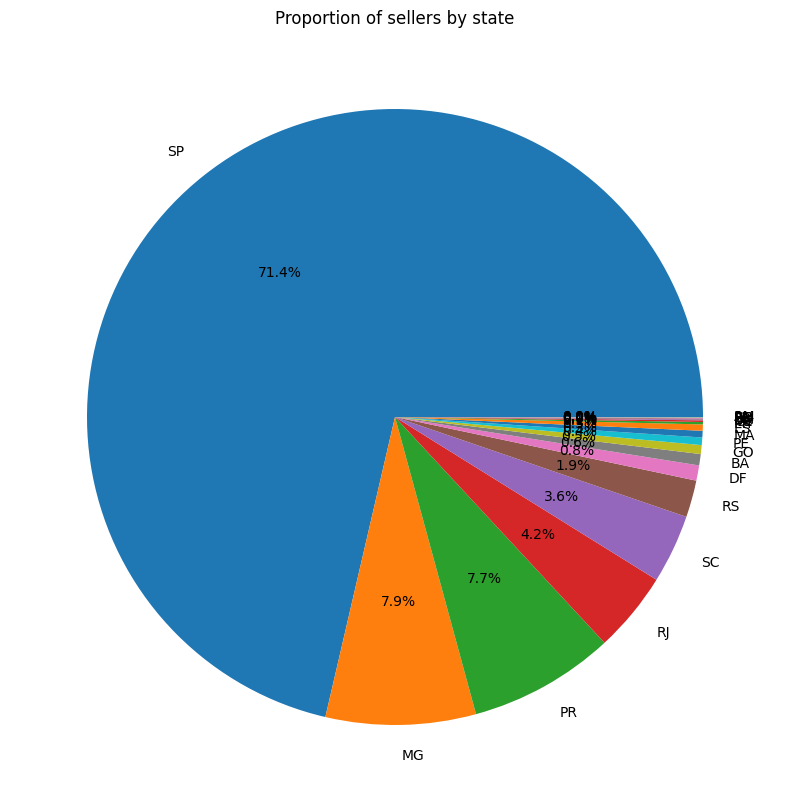

In [6]:
# sellers by state
sellers_by_state = df_details.groupby("seller_state")["seller_id"].count().sort_values(ascending=False)
sellers_by_state = sellers_by_state.reset_index()
sellers_by_state.columns = ["state", "number_of_sellers"]
sellers_by_state["percentage"] = round(sellers_by_state["number_of_sellers"] / sellers_by_state["number_of_sellers"].sum() * 100)

# plot
plt.figure(figsize=(10, 10))
plt.pie(sellers_by_state["number_of_sellers"], labels=sellers_by_state["state"], autopct='%1.1f%%')
plt.title("Proportion of sellers by state")
plt.show()

In [7]:
df_details["seller_state"].unique()

array(['SP', 'MG', 'ES', 'RS', 'DF', 'PR', 'SC', 'RJ', 'GO', 'BA', 'MA',
       'PB', 'PE', 'CE', 'MT', 'PI', 'RN', 'MS', 'PA', 'AM', 'SE', 'RO'],
      dtype=object)

In [8]:
df_details["customer_state"].unique()

array(['SP', 'BA', 'GO', 'RN', 'PR', 'RS', 'RJ', 'MG', 'SC', 'RR', 'PE',
       'TO', 'CE', 'DF', 'SE', 'MT', 'PB', 'PA', 'RO', 'ES', 'AP', 'MS',
       'MA', 'PI', 'AL', 'AC', 'AM'], dtype=object)

In [9]:
# group states by areas
center_west = ["PA", "AC", "AM", "RO", "RR", "AP"]
north_east = ["TO", "MA", "PI", "CE", "RN", "PB", "PE", "AL", "SE", "BA"]
north = ["MS", "MT", "GO", "DF"]
south_east = ["SP", "RJ", "MG", "ES"]
south = ["RS", "SC", "PR"]

In [10]:
def get_area(state):
    if state in center_west:
        return "Center-West"
    elif state in north_east:
        return "North-East"
    elif state in north:
        return "North"
    elif state in south_east:
        return "South-East"
    elif state in south:
        return "South"
    else:
        return "Other"

df_details["customer_area"] = df_details["customer_state"].apply(get_area)
df_details["seller_area"] = df_details["seller_state"].apply(get_area)

## About customers

In [11]:
# Customer by area
customers_by_area = df_details.groupby("customer_area")["customer_unique_id"].count().sort_values(ascending=False)
customers_by_area = customers_by_area.reset_index()
customers_by_area.columns = ["area", "number_of_customers"]
customers_by_area["percentage"] = round(customers_by_area["number_of_customers"] / customers_by_area["number_of_customers"].sum() * 100)

# Define a colormap
color_map = {
    "Center-West": "#EF9B9F",
    "North-East": "#E77818",
    "North": "#84C124",
    "South-East": "#F5DD01",
    "South": "#DB214B",
    "Other": "#F4E2B9",
}
# plot
fig = px.pie(customers_by_area, values="number_of_customers", names="area", title="Proportion of customers by area", color="area", color_discrete_map=color_map)
fig.update_layout(
    title_x=0.5,
    legend=dict(
        x=0.8,
        y=0.5,
        traceorder="normal",
        font=dict(
            size=14,
        )
    )
)
fig.show()

In [12]:
# Sellers by area
sellers_by_area = df_details.groupby("seller_area")["seller_id"].count().sort_values(ascending=False)
sellers_by_area = sellers_by_area.reset_index()
sellers_by_area.columns = ["area", "number_of_sellers"]
sellers_by_area["percentage"] = round(sellers_by_area["number_of_sellers"] / sellers_by_area["number_of_sellers"].sum() * 100)

# plot
fig = px.pie(sellers_by_area, values="number_of_sellers", names="area", title="Proportion of sellers by area", color="area", color_discrete_map=color_map)
fig.update_layout(
    title_x=0.5,
    legend=dict(
        x=0.8,
        y=0.5,
        traceorder="normal",
        font=dict(
            size=14,
        ),
    ),
)
fig.show()

## Missing values ?

### Function

In [5]:
def display_missing_values(df):
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    missing_values = missing_values.sort_values(ascending=False)
    missing_values = missing_values.reset_index()
    missing_values.columns = ["column", "missing_values"]
    return missing_values

In [6]:
# check for missing values per features
display_missing_values(df_details)

,column,missing_values
0,order_delivered_customer_date,2540
1,product_category_name_english,1732
2,product_description_lenght,1707
3,product_photos_qty,1707
4,product_category_name,1707
5,order_approved_at,15


### Payments information

#### Enquiry

In [7]:
df_details.loc[df_details["payment_sequential"].isnull()]

,customer_unique_id,customer_state,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,item_price,...,payment_installments,seller_id,seller_state,seller_zip_code_prefix,review_score,review_length,product_description_lenght,product_photos_qty,product_category_name,product_category_name_english


In [8]:
df_details.loc[df_details["order_id"] == "bfbd0f9bdef84302105ad712db648a6c"]

,customer_unique_id,customer_state,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,item_price,...,payment_installments,seller_id,seller_state,seller_zip_code_prefix,review_score,review_length,product_description_lenght,product_photos_qty,product_category_name,product_category_name_english


In [9]:
# we can replace the missing values as it was a 3 times payment
# But it is an old order so we can drop it

In [10]:
df_details["payment_type"].unique()

array(['credit_card', 'voucher', 'boleto', 'debit_card'], dtype=object)

In [11]:
# Who is this customer
df_details.loc[df_details["customer_unique_id"] == "830d5b7aaa3b6f1e9ad63703bec97d23"]

,customer_unique_id,customer_state,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,item_price,...,payment_installments,seller_id,seller_state,seller_zip_code_prefix,review_score,review_length,product_description_lenght,product_photos_qty,product_category_name,product_category_name_english


#### Solution

This customer seems to have ordered only once, quite a long time ago. Since we can't explain why payment information is not available, we decided to drop these rows.

In [12]:
df_details.dropna(subset=["payment_sequential"], inplace=True)
display_missing_values(df_details)

,column,missing_values
0,order_delivered_customer_date,2540
1,product_category_name_english,1732
2,product_description_lenght,1707
3,product_photos_qty,1707
4,product_category_name,1707
5,order_approved_at,15


### Product categories information

#### Enquiry

Let's have a look on missing product_category_name.

In [13]:
# Get rows of categories name where the translation is not available
df_details.loc[df_details["product_category_name_english"].isnull()]["product_category_name"].unique()

array([None, 'portateis_cozinha_e_preparadores_de_alimentos', 'pc_gamer'],
      dtype=object)

In [14]:
df_details.loc[df_details["product_category_name"].isin(["portateis_cozinha_e_preparadores_de_alimentos", "pc_gamer"])]

,customer_unique_id,customer_state,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,item_price,...,payment_installments,seller_id,seller_state,seller_zip_code_prefix,review_score,review_length,product_description_lenght,product_photos_qty,product_category_name,product_category_name_english
1087,24a0683609e642fe0d86e5e2c97712f5,SP,18190,8dbdb81783a3c754dc9441826510a36a,delivered,2018-08-10 14:54:25,2018-08-10 15:10:27,2018-08-17 20:51:49,2018-08-30 00:00:00,102.90,...,2,7aa538dd6e114e503a2e6154ea352253,SP,15807,4,160,792.0,4.0,portateis_cozinha_e_preparadores_de_alimentos,None
2625,949921a7831eb8901f75baf57d1853bf,SP,7174,e4aac63ea6f6b75b6d91ead05207fb43,delivered,2017-05-25 12:51:37,2017-05-25 13:05:42,2017-06-02 09:44:29,2017-06-07 00:00:00,129.99,...,3,2138ccb85b11a4ec1e37afbd1c8eda1f,SP,8250,5,0,621.0,4.0,pc_gamer,None
8803,ee94c6489208799271238c965bdbd1ac,SP,6784,b35a771164a9defa3b4767f1b66918b1,delivered,2018-07-23 00:49:15,2018-07-25 02:50:18,2018-08-03 10:03:31,2018-07-31 00:00:00,21.52,...,1,ed8cb7b190ceb6067227478e48cf8dde,SP,11015,3,0,305.0,1.0,portateis_cozinha_e_preparadores_de_alimentos,None
10649,2f8c498249d784bf07fae8692d4355d9,SP,6329,b1829b9fc61d2f28d8668cd5bde29e3f,delivered,2018-07-20 01:38:27,2018-07-20 01:50:13,2018-07-28 15:26:43,2018-07-30 00:00:00,17.42,...,1,ed8cb7b190ceb6067227478e48cf8dde,SP,11015,2,170,284.0,1.0,portateis_cozinha_e_preparadores_de_alimentos,None
13266,6a3edb309612a38197be6e1bcb0d3dea,MG,36918,542dd8c7a80f7006b56c9cbb95e6433b,delivered,2018-07-20 17:53:08,2018-07-20 18:05:18,2018-07-30 22:54:34,2018-08-08 00:00:00,34.90,...,1,ea1776927851da2532aa70d6a32c095a,SP,8223,2,0,382.0,2.0,portateis_cozinha_e_preparadores_de_alimentos,None
13726,11b47516f8f6a42105b9807903ede333,RJ,26383,d7ae3c10c3a4c7a721e64ba401ee745b,delivered,2018-02-20 14:59:40,2018-02-20 15:10:43,2018-03-03 17:42:36,2018-03-19 00:00:00,129.99,...,10,2138ccb85b11a4ec1e37afbd1c8eda1f,SP,8250,1,63,621.0,4.0,pc_gamer,None
20326,ef3210ff1b594a76939d1b3686e7fd02,RS,91040,7faf8b9448b66f4a3ac98a312b3e7609,delivered,2018-05-08 17:18:14,2018-05-08 17:35:18,2018-05-15 17:05:57,2018-06-05 00:00:00,979.00,...,8,ba90964cff9b9e0e6f32b23b82465f7b,SP,7140,5,0,1372.0,5.0,portateis_cozinha_e_preparadores_de_alimentos,None
20416,c2a5eec54c809c66e868cd63099ce3d5,SP,9210,2ad4df0af7a71d632dccc0129bee3268,canceled,2018-07-30 12:04:19,2018-07-30 18:31:05,None,2018-08-02 00:00:00,239.00,...,3,1961c3e1272bfeceb05d0b78b5bbfdaf,SP,7241,1,84,840.0,6.0,pc_gamer,None
31686,bd3c54cfb4d231a2b0d7f26b3f9549de,SP,6700,d94600e5b855ffe8db3b9bc06e21b1bd,delivered,2018-07-27 14:33:28,2018-07-28 03:35:16,2018-07-31 21:22:11,2018-08-06 00:00:00,17.53,...,1,ed8cb7b190ceb6067227478e48cf8dde,SP,11015,1,60,280.0,1.0,portateis_cozinha_e_preparadores_de_alimentos,None
31687,bd3c54cfb4d231a2b0d7f26b3f9549de,SP,6700,d94600e5b855ffe8db3b9bc06e21b1bd,delivered,2018-07-27 14:33:28,2018-07-28 03:35:16,2018-07-31 21:22:11,2018-08-06 00:00:00,17.53,...,1,ed8cb7b190ceb6067227478e48cf8dde,SP,11015,1,60,280.0,1.0,portateis_cozinha_e_preparadores_de_alimentos,None


#### Solution

In [15]:
# replace none with value depending on original category value
df_details.loc[df_details["product_category_name"] == "portateis_cozinha_e_preparadores_de_alimentos", "product_category_name_english"] = "portable_kitchen_and_food_preparation_devices"
df_details.loc[df_details["product_category_name"] == "pc_gamer", "product_category_name_english"] = "pc_gamer"

In [16]:
display_missing_values(df_details)

,column,missing_values
0,order_delivered_customer_date,2540
1,product_description_lenght,1707
2,product_photos_qty,1707
3,product_category_name,1707
4,product_category_name_english,1707
5,order_approved_at,15


In [17]:
# Drop rows with missing values
df_details.dropna(subset=["product_category_name_english"], inplace=True)
display_missing_values(df_details)

,column,missing_values
0,order_delivered_customer_date,2469
1,order_approved_at,14


## Processing

### Enquiry

In [18]:
df_details["order_approved_at"].isna().sum()

np.int64(14)

In [19]:
df_details.loc[df_details["order_approved_at"].isna()]

,customer_unique_id,customer_state,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,item_price,...,payment_installments,seller_id,seller_state,seller_zip_code_prefix,review_score,review_length,product_description_lenght,product_photos_qty,product_category_name,product_category_name_english
6230,8a9a08c7ca8900a200d83cf838a07e0b,SP,6708,e04abd8149ef81b95221e88f6ed9ab6a,delivered,2017-02-18 14:40:00,None,2017-03-01 13:25:33,2017-03-17 00:00:00,309.90,...,1,4e7c18b98d84e05cbae3ff0ff03846c2,SP,14882,4,38,675.0,2.0,eletroportateis,small_appliances
19571,91efb7fcabc17925099dced52435837f,RS,93548,8a9adc69528e1001fc68dd0aaebbb54a,delivered,2017-02-18 12:45:31,None,2017-03-02 10:05:06,2017-03-21 00:00:00,379.00,...,1,a4b6b9b992b46e9ef863637af96e04bc,SC,88090,5,0,498.0,1.0,construcao_ferramentas_seguranca,construction_tools_safety
26822,7e1a5ca61b572d76b64b6688b9f96473,CE,62700,5cf925b116421afa85ee25e99b4c34fb,delivered,2017-02-18 16:48:35,None,2017-03-09 07:28:47,2017-03-31 00:00:00,79.99,...,1,7a67c85e85bb2ce8582c35f2203ad736,SP,3426,5,0,1012.0,1.0,cool_stuff,cool_stuff
27413,c8822fce1d0bfa7ddf0da24fff947172,RJ,27945,12a95a3c06dbaec84bcfb0e2da5d228a,delivered,2017-02-17 13:05:55,None,2017-03-02 11:09:19,2017-03-20 00:00:00,79.99,...,1,7a67c85e85bb2ce8582c35f2203ad736,SP,3426,5,0,1012.0,1.0,cool_stuff,cool_stuff
31779,6ff8b0d7b35d5c945633b8d60165691b,SP,11030,c1d4211b3dae76144deccd6c74144a88,delivered,2017-01-19 12:48:08,None,2017-01-30 18:16:01,2017-03-01 00:00:00,39.99,...,1,80e6699fe29150b372a0c8a1ebf7dcc8,PR,83323,4,56,1322.0,2.0,esporte_lazer,sports_leisure
45430,2e0a2166aa23da2472c6a60c4af6f7a6,SP,3573,d69e5d356402adc8cf17e08b5033acfb,delivered,2017-02-19 01:28:47,None,2017-03-02 03:41:58,2017-03-27 00:00:00,149.80,...,1,cca3071e3e9bb7d12640c9fbe2301306,SP,14940,5,17,586.0,1.0,moveis_decoracao,furniture_decor
46678,c4c0011e639bdbcf26059ddc38bd3c18,SP,13225,d77031d6a3c8a52f019764e68f211c69,delivered,2017-02-18 11:04:19,None,2017-03-02 16:15:23,2017-03-22 00:00:00,28.99,...,1,cb3dd9ce66268c7a3ca7241ac70ab58c,SP,3028,5,44,1738.0,1.0,esporte_lazer,sports_leisure
57393,d49f3dae6bad25d05160fc17aca5942d,MG,36400,7002a78c79c519ac54022d4f8a65e6e8,delivered,2017-01-19 22:26:59,None,2017-02-06 14:22:19,2017-03-16 00:00:00,45.90,...,1,cca3071e3e9bb7d12640c9fbe2301306,SP,14940,2,98,473.0,1.0,moveis_decoracao,furniture_decor
73024,5a4fa4919cbf2b049e72be460a380e5b,MG,35620,2eecb0d85f281280f79fa00f9cec1a95,delivered,2017-02-17 17:21:55,None,2017-03-03 12:16:03,2017-03-20 00:00:00,135.00,...,1,5fd924b4836098a5be0ecf81ba054ce0,SP,3554,5,0,441.0,3.0,ferramentas_jardim,garden_tools
74577,79af1bbf230a2630487975aa5d7d6220,MG,37660,51eb2eebd5d76a24625b31c33dd41449,delivered,2017-02-18 15:52:27,None,2017-03-07 13:57:47,2017-03-29 00:00:00,59.90,...,1,cca3071e3e9bb7d12640c9fbe2301306,SP,14940,5,0,438.0,1.0,moveis_decoracao,furniture_decor


Missing values in the approval state are all delivered orders. We shall replace with a median value. 

### Solution

In [20]:
# get the day of order_approved_at and order_purchase_timestamp
df_details["order_approved_at"] = pd.to_datetime(df_details["order_approved_at"])
df_details["order_purchase_timestamp"] = pd.to_datetime(df_details["order_purchase_timestamp"])


In [21]:
# get the difference between order_approved_at and order_purchase_timestamp
df_details["order_processing_time"] = df_details["order_approved_at"] - df_details["order_purchase_timestamp"]
df_details["order_processing_time"] = df_details["order_processing_time"].dt.days

In [22]:
# replacing NaN with median
median_processing_time = df_details["order_processing_time"].median()
df_details["order_processing_time"].fillna(median_processing_time, inplace=True)

/var/folders/4f/ml64c07d1zsg_jvvydhyltjr0000gn/T/ipykernel_10483/2882115909.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_details["order_processing_time"].fillna(median_processing_time, inplace=True)


# CUSTOMER INFO FINAL DATAFRAME

For the time allowed to our study, we will not be able to work on all features, so we will get rid of few.

In [23]:
df_temp = df_details.drop(
    columns=[
        "order_approved_at",
        "customer_state",
        "seller_state",
        "seller_zip_code_prefix",
        "customer_zip_code_prefix",
        "seller_id",
        "product_description_lenght",
        "product_description_lenght",
        "product_photos_qty",
        "product_category_name",
        "review_length",
    ]
)
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116211 entries, 0 to 117917
Data columns (total 15 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_unique_id             116211 non-null  object        
 1   order_id                       116211 non-null  object        
 2   order_status                   116211 non-null  object        
 3   order_purchase_timestamp       116211 non-null  datetime64[ns]
 4   order_delivered_customer_date  113742 non-null  object        
 5   order_estimated_delivery_date  116211 non-null  object        
 6   item_price                     116211 non-null  float64       
 7   freight_value                  116211 non-null  float64       
 8   payment_value                  116211 non-null  float64       
 9   payment_sequential             116211 non-null  int64         
 10  payment_type                   116211 non-null  object        
 11  payme

The goal of our model is to create clusters of customers, this is why we need to have a row for each customer information.

To do so, we will group the data per customer and will get the following :
- get the number of order made by a customer
- get the number of cancelled orders
- the average time a customer is ordering
- the average amount spent per order
- the total expense
- the number of products ordered per category
- the number of order for different states
- the proportion of reviews left
- the average score left
- 

## Dealing with dates

### Format

The first step would be to work on the date management. We are interested only in dates, except for the purchased time that could give an information about the day moment a customer would e-shop.

In [24]:
# Step 1 : Transform date columns to datetime
df_temp["order_delivered_customer_date"] = pd.to_datetime(df_temp["order_delivered_customer_date"])
df_temp["order_estimated_delivery_date"] = pd.to_datetime(df_temp["order_estimated_delivery_date"])

# Step 2 : Extract the time the order was purchased from the timestamp
df_temp["order_purchase_time"] = df_temp["order_purchase_timestamp"].dt.time

# Step 3 : Keep only the date part of the order purchase, delivered and estimated delivery dates
df_temp["order_purchase_date"] = df_temp["order_purchase_timestamp"].dt.date
print(f"Last order was on the {df_temp['order_purchase_date'].max()}")
df_temp["order_delivered_customer_date"] = df_temp["order_delivered_customer_date"].dt.date
last_delivery_date = df_temp.loc[df_temp['order_delivered_customer_date'].notnull()]['order_delivered_customer_date'].max()
print(f"Last registered delivery was on {last_delivery_date}")
df_temp["order_estimated_delivery_date"] = df_temp["order_estimated_delivery_date"].dt.date
print(f"Latest delivery estimated was on {df_temp['order_estimated_delivery_date'].max()}")

# Orders after the last registered delivery date
df_temp.loc[
    df_temp["order_estimated_delivery_date"] > last_delivery_date]

print("All the orders planned to be received after the last registered delivery date have been delivered.")
print("We can consider that all data without a delevery date are not delivered yet.")

# Get the delivery delay
df_temp["delivery_delay"] = df_temp["order_delivered_customer_date"] - df_temp["order_purchase_date"]

# Add a column for late delivery
df_temp["days_late_count"] = df_temp["order_delivered_customer_date"] - df_temp["order_estimated_delivery_date"]
df_temp["days_late_count"] = pd.to_timedelta(df_temp["days_late_count"]).dt.days
df_temp["days_late_count"] = df_temp["days_late_count"].apply(
    lambda x: x if x > 0 else 0
)
# Get rid of original timestamp columns
df_temp.drop(
    columns=[
        "order_purchase_timestamp",
        "order_delivered_customer_date",
        "order_estimated_delivery_date"
    ],
    inplace=True,
)

df_temp.head()

Last order was on the 2018-09-03
Last registered delivery was on 2018-10-17
Latest delivery estimated was on 2018-10-25
All the orders planned to be received after the last registered delivery date have been delivered.
We can consider that all data without a delevery date are not delivered yet.


,customer_unique_id,order_id,order_status,item_price,freight_value,payment_value,payment_sequential,payment_type,payment_installments,review_score,product_category_name_english,order_processing_time,order_purchase_time,order_purchase_date,delivery_delay,days_late_count
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,delivered,29.99,8.72,18.12,1,credit_card,1,4,housewares,0.0,10:56:33,2017-10-02,"8 days, 0:00:00",0.0
1,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,delivered,29.99,8.72,18.59,2,voucher,1,4,housewares,0.0,10:56:33,2017-10-02,"8 days, 0:00:00",0.0
2,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,delivered,29.99,8.72,2.00,3,voucher,1,4,housewares,0.0,10:56:33,2017-10-02,"8 days, 0:00:00",0.0
3,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,delivered,118.70,22.76,141.46,1,boleto,1,4,perfumery,1.0,20:41:37,2018-07-24,"14 days, 0:00:00",0.0
4,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,delivered,159.90,19.22,179.12,1,credit_card,3,5,auto,0.0,08:38:49,2018-08-08,"9 days, 0:00:00",0.0


### Get the moment of the day a customer ordered

In [25]:
# Create bins for the order purchased time
bins = [0, 6, 12, 14, 18, 24]
labels = ["Night", "Morning", "Noon", "Afternoon", "Evening"]
df_temp["order_purchase_hour"] = df_temp["order_purchase_time"].apply(lambda x: x.hour)
df_temp["order_purchase_time_bin"] = pd.cut(df_temp["order_purchase_hour"], bins=bins, labels=labels, right=False)

# drop column
df_temp.drop(columns=["order_purchase_time", "order_purchase_hour"], inplace=True)
df_temp.head()

,customer_unique_id,order_id,order_status,item_price,freight_value,payment_value,payment_sequential,payment_type,payment_installments,review_score,product_category_name_english,order_processing_time,order_purchase_date,delivery_delay,days_late_count,order_purchase_time_bin
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,delivered,29.99,8.72,18.12,1,credit_card,1,4,housewares,0.0,2017-10-02,"8 days, 0:00:00",0.0,Morning
1,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,delivered,29.99,8.72,18.59,2,voucher,1,4,housewares,0.0,2017-10-02,"8 days, 0:00:00",0.0,Morning
2,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,delivered,29.99,8.72,2.00,3,voucher,1,4,housewares,0.0,2017-10-02,"8 days, 0:00:00",0.0,Morning
3,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,delivered,118.70,22.76,141.46,1,boleto,1,4,perfumery,1.0,2018-07-24,"14 days, 0:00:00",0.0,Evening
4,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,delivered,159.90,19.22,179.12,1,credit_card,3,5,auto,0.0,2018-08-08,"9 days, 0:00:00",0.0,Morning


In [26]:
# Plot a graph of the number of orders by time of the day
orders_by_time = (
    df_temp.groupby("order_purchase_time_bin")["order_id"]
    .count()
    .sort_values(ascending=False)
)
orders_by_time = orders_by_time.reset_index()
orders_by_time.columns = ["time", "number_of_orders"]

# Calculate the ratio
total_orders = orders_by_time["number_of_orders"].sum()
orders_by_time["ratio"] = round((orders_by_time["number_of_orders"] / total_orders)*100, 2)
# Format the ratio as a string with "%"
orders_by_time["ratio"] = orders_by_time["ratio"].astype(str) + "%"

fig = px.bar(orders_by_time, x="time", y="number_of_orders", title="Number of orders by time of the day", text="ratio")
fig.show()

/var/folders/4f/ml64c07d1zsg_jvvydhyltjr0000gn/T/ipykernel_10483/2752922295.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp.groupby("order_purchase_time_bin")["order_id"]


## Count canceled orders

In [27]:
# In order to count the number of cancelled order  per customer
df_temp["canceled_orders"] = df_temp["order_status"].apply(
    lambda x: 1 if x == "canceled" else 0
)
df_temp.loc[df_temp["order_status"] == "canceled"]

,customer_unique_id,order_id,order_status,item_price,freight_value,payment_value,payment_sequential,payment_type,payment_installments,review_score,product_category_name_english,order_processing_time,order_purchase_date,delivery_delay,days_late_count,order_purchase_time_bin,canceled_orders
467,8ea097b1824dbd4d17af71b0afe04301,1b9ecfe83cdc259250e1a8aca174f0ad,canceled,25.0,8.34,33.34,1,boleto,1,1,computers_accessories,2.0,2018-08-04,NaN,0.0,Afternoon,1
733,c4ebedb09beb89cc0314c5c0c33f8053,714fb133a6730ab81fa1d3c1b2007291,canceled,69.9,26.11,96.01,1,credit_card,4,1,furniture_decor,0.0,2018-01-26,NaN,0.0,Evening,1
734,c4ebedb09beb89cc0314c5c0c33f8053,714fb133a6730ab81fa1d3c1b2007291,canceled,69.9,26.11,96.01,1,credit_card,4,1,furniture_decor,0.0,2018-01-26,NaN,0.0,Evening,1
1265,11c3d6c93dea6ce86769a4835c171bd9,3a129877493c8189c59c60eb71d97c29,canceled,35.9,15.10,14.12,1,credit_card,1,1,sports_leisure,0.0,2018-01-25,NaN,0.0,Noon,1
1266,11c3d6c93dea6ce86769a4835c171bd9,3a129877493c8189c59c60eb71d97c29,canceled,35.9,15.10,36.88,2,voucher,1,1,sports_leisure,0.0,2018-01-25,NaN,0.0,Noon,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117104,82ec5f749b66f1857e868b6414a67ab3,5a8a4dc28b16fb90469ad749f9535773,canceled,149.0,11.67,321.34,1,boleto,1,5,garden_tools,0.0,2018-03-13,NaN,0.0,Morning,1
117105,82ec5f749b66f1857e868b6414a67ab3,5a8a4dc28b16fb90469ad749f9535773,canceled,149.0,11.67,321.34,1,boleto,1,5,garden_tools,0.0,2018-03-13,NaN,0.0,Morning,1
117129,78a159045124eb7601951b917a42034f,b159d0ce7cd881052da94fa165617b05,canceled,19.7,10.96,30.66,1,credit_card,1,1,auto,0.0,2017-03-11,NaN,0.0,Evening,1
117573,0f75924cbbe60142068f4029d744b724,6560fb10610771449cb0463c5ba12199,canceled,150.0,16.81,333.62,1,credit_card,3,1,computers_accessories,0.0,2017-10-01,NaN,0.0,Evening,1


## Evaluate deliveries delays

In [28]:
df_temp["delivery_delay"].isna().sum()

np.int64(2469)

In [29]:
#convert delivery_delay into integer
df_temp["delivery_delay"] = pd.to_timedelta(df_temp["delivery_delay"]).dt.days

# As we do not have the information regarding the missing deliveries, we decided to replace the missing values by the median of the column only if not cacelled delivery
median_delivery_delay = df_temp[df_temp["order_status"] != "canceled"][
    "delivery_delay"
].median()
df_temp.loc[
    (df_temp["order_status"] != "canceled") & (df_temp["delivery_delay"].isna()),
    "delivery_delay",
] = median_delivery_delay
df_temp["delivery_delay"].isna().sum()

np.int64(539)

## Save orders DF

Before going any further, we are going to save this dataset. It will help us working on the clustering update.

In [30]:
# Save th dataset to  pickle file
df_temp.to_pickle("../data/df_orders_details.pkl")

Now we can aggregate all data to get a customer informations set

In [31]:
# Change dates column to pd.datetime
df_temp["order_purchase_date"] = pd.to_datetime(df_temp["order_purchase_date"])

current_date = pd.to_datetime("2018-09-04")
# Get the average number of days between orders for each customer
df_sorted = df_temp.sort_values(by=["customer_unique_id", "order_purchase_date"])
df_grouped = df_sorted.groupby("customer_unique_id")

df_customers = df_grouped.agg(
    first_order_date=("order_purchase_date", "min"),
    last_order_date=("order_purchase_date", "max"),
    total_orders=("order_id", "count"),
    average_processing_time=("order_processing_time", "mean"),
    cancelled_orders=("canceled_orders", "sum"),
    total_expenses=("payment_value", "sum"),
    total_items_values=("item_price", "sum"),
    total_freight_value=("freight_value", "sum"),
    average_order_value=("payment_value", "mean"),
    average_freight_value=("freight_value", "mean"),
    average_payment_installement=("payment_installments", "mean"),
    most_used_payment_method=("payment_type", lambda x: x.mode()[0]),
    usual_moment_of_order_str=("order_purchase_time_bin", lambda x: x.mode()[0]),
    most_ordered_category=("product_category_name_english", lambda x: x.mode()[0]),
    number_of_different_categories=("product_category_name_english", "nunique"),
    average_review_score=("review_score", "mean"),
    average_delivery_delays=("delivery_delay", "mean"),
    average_days_late=("days_late_count", "mean"),
)

# Calculate the average days between orders if more than one order
df_sorted["days_since_previous_orders"] = (
    df_grouped["order_purchase_date"].diff().dt.days.fillna(0)
)

average_days_between_orders = (
    df_sorted.groupby("customer_unique_id")["days_since_previous_orders"]
    .mean()
    .fillna(0)
)

df_customers = df_customers.reset_index()

# Calculate the number of days since the last order
df_customers["days_since_last_order"] = (current_date - df_customers["last_order_date"]).dt.days

# Add average days between orders to the customers dataframe
df_customers = df_customers.merge(average_days_between_orders.rename("average_days_between_orders"), on="customer_unique_id", how="left")

# drop customers with only 1 order that was cancelled
df_customers = df_customers[
    (df_customers["total_orders"] >= 1) | (df_customers["cancelled_orders"] == 0)
]

# how long a customer is a customer
df_customers["days_as_customer"] = (df_customers["last_order_date"] - df_customers["first_order_date"]).dt.days
# replace firstime customers with 1
df_customers["days_as_customer"] = df_customers["days_as_customer"].apply(lambda x: 1 if x == 0 else x)

# drop rows where total orders = total cancelled orders
df_customers = df_customers[df_customers["total_orders"] != df_customers["cancelled_orders"]]

df_customers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93406 entries, 0 to 93810
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   customer_unique_id              93406 non-null  object        
 1   first_order_date                93406 non-null  datetime64[ns]
 2   last_order_date                 93406 non-null  datetime64[ns]
 3   total_orders                    93406 non-null  int64         
 4   average_processing_time         93406 non-null  float64       
 5   cancelled_orders                93406 non-null  int64         
 6   total_expenses                  93406 non-null  float64       
 7   total_items_values              93406 non-null  float64       
 8   total_freight_value             93406 non-null  float64       
 9   average_order_value             93406 non-null  float64       
 10  average_freight_value           93406 non-null  float64       
 11  average

## working on categories

### Time of ordering

In [32]:
# Ordinal encoding of time of the day
# We will use the following order : Night < Morning < Noon < Afternoon < Evening
time_of_day_order = ["Night", "Morning", "Noon", "Afternoon", "Evening"]
df_customers["usual_moment_of_order_int"] = df_customers["usual_moment_of_order_str"].apply(
    lambda x: time_of_day_order.index(x)
)


# SAVE DATAFRAMES

In [33]:
# Save to pickle
df_customers.to_pickle("../data/customers.pkl")